In [1]:
from rdkit import Chem
from rdkit.Chem import rdmolops
import random

def crossover(parent1_smiles, parent2_smiles):
    parent1_mol = Chem.MolFromSmiles(parent1_smiles)
    parent2_mol = Chem.MolFromSmiles(parent2_smiles)

    # Identify suitable breaking points (e.g., between donor atoms and the rest of the molecule)
    # For simplicity, this example randomly selects bonds to break
    bond1 = random.choice([bond.GetIdx() for bond in parent1_mol.GetBonds()])
    bond2 = random.choice([bond.GetIdx() for bond in parent2_mol.GetBonds()])

    # Split molecules into fragments
    frags1 = Chem.GetMolFrags(Chem.FragmentOnBonds(parent1_mol, [bond1]), asMols=True, sanitizeFrags=True)
    frags2 = Chem.GetMolFrags(Chem.FragmentOnBonds(parent2_mol, [bond2]), asMols=True, sanitizeFrags=True)

    # Randomly pair fragments to form new molecules; you might want to implement logic to preferentially keep chelating parts intact
    new_mols = [Chem.CombineMols(frags1[0], frags2[1]), Chem.CombineMols(frags2[0], frags1[1])]

    # Convert back to SMILES and ensure validity
    new_smiles = [Chem.MolToSmiles(mol) for mol in new_mols if mol]

    return new_smiles


In [ ]:
def mutate(smiles, mutation_rate):
    mol = Chem.MolFromSmiles(smiles)

    # Decide randomly whether to mutate, based on mutation rate
    if random.random() < mutation_rate:
        # Choose a mutation type: addition or modification of a functional group
        if random.random() > 0.5:
            # For simplicity, consider adding a hydroxyl group; real implementation might add different chelating functionalities
            atom_idx = random.randint(0, mol.GetNumAtoms() - 1)
            edit_mol = Chem.RWMol(mol)
            oxygen_atom = Chem.Atom('O')
            oxygen_atom.SetFormalCharge(0)
            new_atom_idx = edit_mol.AddAtom(oxygen_atom)
            edit_mol.AddBond(atom_idx, new_atom_idx, Chem.BondType.SINGLE)
            mol = edit_mol.GetMol()
        else:
            # Modify an existing atom to a different chelating atom, like turning a carbon into an oxygen or a nitrogen
            atom_idx = random.randint(0, mol.GetNumAtoms() - 1)
            edit_mol = Chem.RWMol(mol)
            target_atom = edit_mol.GetAtomWithIdx(atom_idx)
            if target_atom.GetSymbol() == 'C':  # Example: change C to N
                target_atom.SetAtomicNum(7)  # Atomic number for Nitrogen
            mol = edit_mol.GetMol()

    new_smiles = Chem.MolToSmiles(mol) if mol else None
    return new_smiles


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Load your dataset
data = pd.read_csv('./logK.csv')  # Change this to your file path

# Function to check if molecule contains only allowed elements
def contains_only_allowed_elements(smiles, allowed_elements={'C', 'H', 'O', 'N', 'P', 'S'}):
    mol = Chem.MolFromSmiles(smiles)
    return all(atom.GetSymbol() in allowed_elements for atom in mol.GetAtoms())

# Function to count the number of atoms of certain elements
def count_atoms(smiles, elements={'O', 'N', 'P', 'S'}):
    mol = Chem.MolFromSmiles(smiles)
    return sum(atom.GetSymbol() in elements for atom in mol.GetAtoms())

# Filtering the dataset
filtered_data = []
for _, row in data.iterrows():
    smiles = row['smiles']
    if contains_only_allowed_elements(smiles):
        if len(set(smiles) & {'C', 'H', 'O', 'N', 'P', 'S'}) >= 3:  # At least three different elements
            if count_atoms(smiles) <= 12:  # No more than 12 of O, N, P, S
                mol = Chem.MolFromSmiles(smiles)
                molecular_weight = Descriptors.ExactMolWt(mol)
                if molecular_weight <= 500:  # Molecular weight <= 500 Da
                    filtered_data.append(row)

# Convert filtered data back to a DataFrame
filtered_df = pd.DataFrame(filtered_data)

# Save the filtered data to a new CSV file
filtered_df.to_csv('filtered_logK.csv', index=False)

# Display the first few rows of the filtered dataset
print(filtered_df.head())


    id                                     smiles   lgK
7    7  O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO  2.85
8    8     O=C([O-])C1(O)C[C@@H](O)C(O)[C@H](O)C1  2.95
32  32             O=C(O)[C@H]1CC[C@H](C(=O)O)CC1  4.35
35  35                      O=C(O)C[C@H](O)C(=O)O  5.08
36  36              O=C(O)[C@H](O)[C@@H](O)C(=O)O  4.32


<Axes: >

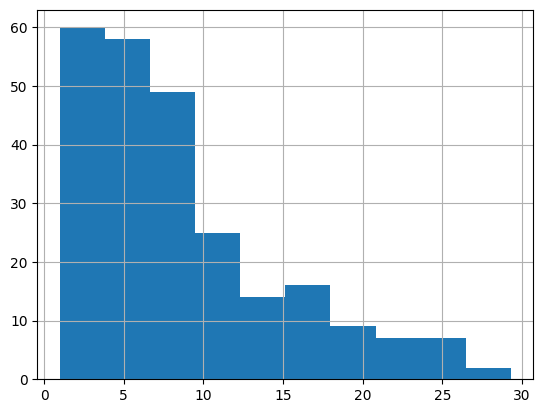

In [3]:
data.lgK.hist()

In [18]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
import random

# Initialize seed molecules
seed_smiles = ['OCCN', 'CC(=O)O', 'NCCS']  # Replace with your initial chelators
seed_molecules = [Chem.MolFromSmiles(smile) for smile in seed_smiles]

# Mutation function: This is a simple example; you'll need more complex logic.
def mutate_molecule(molecule):
    # Example: remove a random atom (not a hydrogen atom)
    if molecule.GetNumAtoms() > 1:  # Prevent removing all atoms
        idx_to_remove = random.choice([atom.GetIdx() for atom in molecule.GetAtoms() if atom.GetSymbol() != 'H'])
        edmol = Chem.EditableMol(molecule)
        edmol.RemoveAtom(idx_to_remove)
        new_mol = edmol.GetMol()
        return new_mol
    return molecule

# Property check function (Example: Molecular Weight)
def check_properties(molecule):
    mw = Descriptors.MolWt(molecule)
    if mw <= 500:  # Check molecular weight
        return True
    return False

# Main loop: mutate and check properties
new_molecules = []
for mol in seed_molecules:
    new_mol = mutate_molecule(mol)
    if new_mol and check_properties(new_mol):
        new_smiles = Chem.MolToSmiles(new_mol)
        new_molecules.append(new_smiles)

# Print out new molecules' SMILES
print("New Molecules (SMILES):")
for smiles in new_molecules:
    print(smiles)

# Note: Implement lgK prediction and further checks as needed.


New Molecules (SMILES):
CO.N
CC=O
CCS


In [20]:
! pip install catboost -q

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import pandas as pd
from catboost import CatBoostRegressor


class CatLgKPredictor:
    
    def __init__(self, model_path) -> None:
        self.reg = CatBoostRegressor().load_model(model_path)
        
    
    # Функция для расчета всех доступных дескрипторов RDKit для молекулы
    def calculate_all_descriptors(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if not mol:  # Если молекула не может быть создана
            return {desc[0]: None for desc in Descriptors.descList}
        
        descriptors = {}
        for desc_name, desc_func in Descriptors.descList:
            try:
                descriptors[desc_name] = desc_func(mol)
            except Exception as e:
                descriptors[desc_name] = None
        return descriptors
    
    # Функция для добавления Morgan Fingerprints
    def add_morgan_fingerprints(self, smiles, n_bits=1024):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
            return list(map(int, fp))
        else:
            return [None] * n_bits
        
    

    def preprocess_data(self, data: pd.DataFrame):
        # Добавляем Morgan Fingerprints
        morgan_fp_df = pd.DataFrame(data['smiles'].apply(lambda x: self.add_morgan_fingerprints(x, 1024)).tolist())
        # Применение функции к каждой SMILES в датасете и создание нового DataFrame с результатами
        descriptors_list = data['smiles'].apply(self.calculate_all_descriptors).tolist()
        descriptors_df = pd.DataFrame(descriptors_list)
        
        # Если требуется, можно объединить исходный DataFrame с новым DataFrame дескрипторов
        combined_data = pd.concat([data, descriptors_df], axis=1)
        
        
        combined_data = combined_data.drop(columns=["smiles", "Molecules"])
        
    def predict_lgK(self, data: pd.DataFrame):
        prep_data = self.preprocess_data(data=data)
        
        preds = self.reg.predict(prep_data)
        
        return preds


In [ ]:
predictor = CatLgKPredictor()